In [1]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.9.2


Declare constants

In [2]:
DATASET_DIR= "./data/tomato"
EPOCHS = 50
BATCH_SIZE = 32
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMAGE_CHANNELS = 3
IMAGE_SHAPE=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
NUM_CLASSES=10

Load Dataset

In [3]:
train_ds = keras.utils.image_dataset_from_directory(
  F"{DATASET_DIR}/train",
  validation_split=0.2,
  subset="training",
  seed=123,
  # image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE,
)

val_ds = keras.utils.image_dataset_from_directory(
  F"{DATASET_DIR}/train",
  validation_split=0.2,
  subset="validation",
  seed=123,
  # image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE,
)

Found 10000 files belonging to 10 classes.
Using 8000 files for training.
Found 10000 files belonging to 10 classes.
Using 2000 files for validation.


preview data

['Bacterial Spot', 'Early Blight', 'Healthy', 'Late Blight', 'Leaf Mold', 'Mosaic Virus', 'Septoria Leaf Spot', 'Target Spot', 'Two Spotted Spider Mite', 'Yellow Leaf Curl Virus']


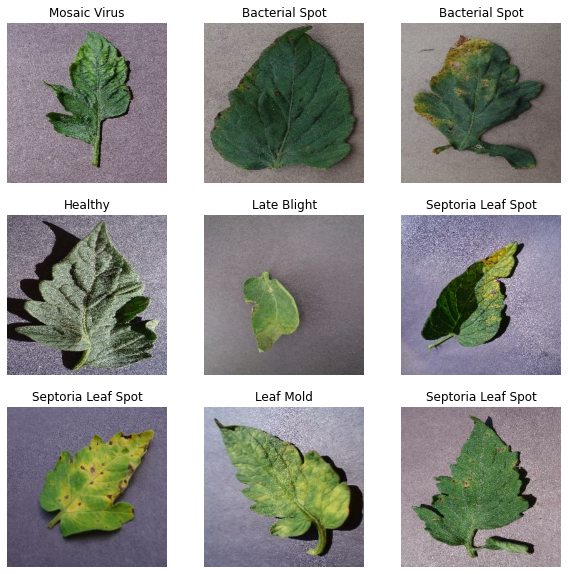

In [4]:
class_names = train_ds.class_names
print(class_names)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# for image_batch, labels_batch in train_ds:
#   print(image_batch.shape)
#   print(labels_batch.shape)
#   break

Data Augmentation pipeline

In [5]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomTranslation(0.2, 0.2),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomBrightness(0.4),
    keras.layers.RandomContrast(0.4),
])

Image Preprocessing pipeline

In [6]:
preprocessing = keras.Sequential([
    keras.layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
    keras.layers.Rescaling(1./255),
])

Prefetch Data and setup augmentation

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Model Architecture

In [8]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(None, None, 3)),

    preprocessing,
    # data_augmentation,

    keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),

    keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),

    keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),

    # keras.layers.Dropout(0.2),

    keras.layers.GlobalAveragePooling2D(),

    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.25),
    # keras.layers.Dense(64, activation="relu"),
    # keras.layers.Dropout(0.2),

    keras.layers.Dense(NUM_CLASSES, activation="softmax")
])


model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

model.summary(
    expand_nested=True,
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| resizing (Resizing)       (None, 128, 128, 3)       0         |
|                                                               |
| rescaling (Rescaling)     (None, 128, 128, 3)       0         |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                      

Training

In [9]:
# earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    # callbacks=[earlystop],
)

Epoch 1/50
250/250 [==============================] - 20s 79ms/step - loss: 1.9274 - sparse_categorical_accuracy: 0.2750 - val_loss: 1.5073 - val_sparse_categorical_accuracy: 0.4775
Epoch 2/50
250/250 [==============================] - 19s 77ms/step - loss: 1.4195 - sparse_categorical_accuracy: 0.4885 - val_loss: 1.2179 - val_sparse_categorical_accuracy: 0.5565
Epoch 3/50
250/250 [==============================] - 20s 79ms/step - loss: 1.1683 - sparse_categorical_accuracy: 0.5773 - val_loss: 0.9602 - val_sparse_categorical_accuracy: 0.6680
Epoch 4/50
250/250 [==============================] - 19s 78ms/step - loss: 0.9811 - sparse_categorical_accuracy: 0.6496 - val_loss: 0.9236 - val_sparse_categorical_accuracy: 0.6775
Epoch 5/50
250/250 [==============================] - 19s 77ms/step - loss: 0.8895 - sparse_categorical_accuracy: 0.6825 - val_loss: 0.8322 - val_sparse_categorical_accuracy: 0.7220
Epoch 6/50
250/250 [==============================] - 19s 74ms/step - loss: 0.7963 - spars

Results

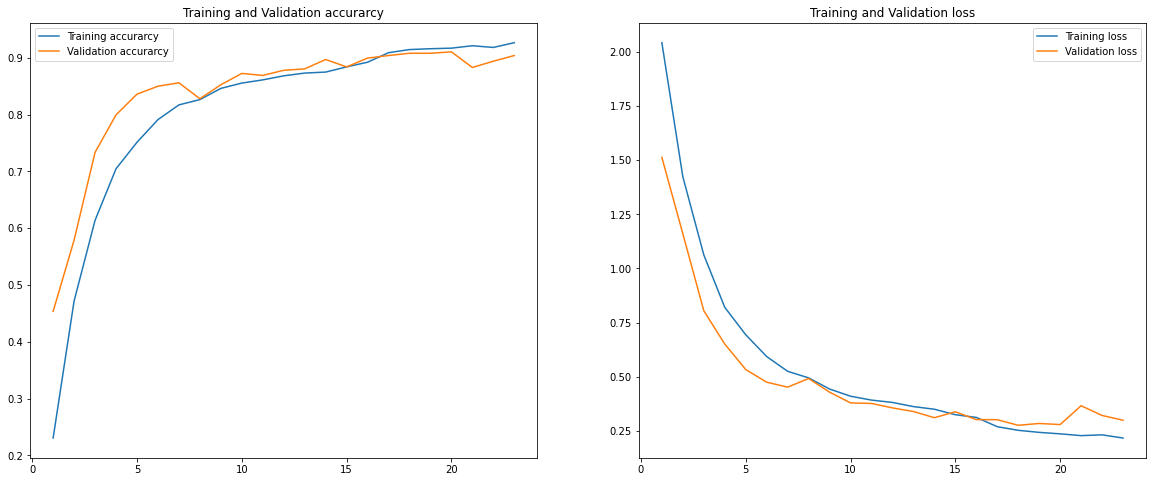

In [ ]:
from matplotlib import pyplot as plt

acc = history.history["sparse_categorical_accuracy"]
val_acc = history.history["val_sparse_categorical_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.ylim((0, 1))
plt.plot(epochs, acc, label="Training accurarcy")
plt.plot(epochs, val_acc, label="Validation accurarcy")
plt.title("Training and Validation accurarcy")
plt.legend()

# Train and validation loss
plt.subplot(1, 2, 2)

plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

In [ ]:
test_ds = keras.utils.image_dataset_from_directory(
  F"{DATASET_DIR}/valid",
  # image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  # batch_size=BATCH_SIZE,
)

results = model.evaluate(test_ds, verbose=0)

print("test accuracy:", results[1]*100)
print("test loss:", results[0]*100)

Found 1000 files belonging to 10 classes.
test accuracy: 92.30000376701355
test loss: 31.38193190097809


In [ ]:
# dot_img_file = '/tmp/model_architecture.png'
# tf.keras.utils.plot_model(
#     model,
#     to_file=dot_img_file,
#     show_shapes=True,
#     show_layer_names=False,
#     expand_nested=True
# )

Prediction

In [ ]:
# print(train_ds.class_indices)

In [ ]:
# import numpy as np

# img = keras.utils.load_img(
#   f"{DATASET_DIR}/test/Leaf smut/smut-_0_2488.jpg",
#   # target_size=(IMAGE_HEIGHT, IMAGE_WIDTH)
# )

# img_array = tf.keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)

# predictions = model.predict(img_array)

# for prediction in predictions:
#   score = tf.nn.softmax(prediction)
#   # class_names = train_ds.class_names
#   print(
#       100*score
#   )

In [ ]:
# def predict(type):
#   img = keras.utils.load_img(
#     f"{DATASET_DIR}/test/Leaf smut/smut-_0_2488.jpg",
#     # target_size=(128, 128)
#   )

#   img_array = tf.keras.utils.img_to_array(img)
#   img_array = tf.expand_dims(img_array, 0)

#   predictions = model.predict(img_array)
#   score = tf.nn.softmax(predictions[0])


#   path = src
#   img_matrix = convert_image_to_array(path)
#   toBePredictedImage = np.expand_dims(img_matrix, axis=0)
  
#   result = model.predict(toBePredictedImage)
#   predictedClass = [np.argmax(element) for element in result]
#   image_folder = path[9:10]
#   boolResult = False
#   if str(image_folder) == str(predictedClass[0]):
#       boolResult = True
#   # print(f"\nPredicted value for {path} --- Predicted Class {predictedClass} --- Result {result} --- Correct???? {boolResult}")
#   return boolResult